# Hacktiv8 - Full Time Data Science Remote Batch 16

# Final Project Group 3

Venu Fitratama<br>
Wenny Sari<br>
Rivaldo Jasper<br>
Muhammad Irfan Hilman<br>
Huesca Rashad<br>
St Syakirah<br>
Monica Pratiwi

## Description

### Objective

`Predicting stock(*) prices using time history analysis with Artificial Neural Networks.`<br>
`(*) : Bank Nasional Indonesia (BBNI), Bank Rakyat Indonesia (BBRI), Bank Tabungan Negara (BBTN), Bank Mandiri (BMRI)`

### Problem Statement

1. What is the repeat period of an event ?
2. 

## Working Area
### 1. Import Libraries

In [91]:
# Basic libraries
import os
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Stock prices scrap
from selenium import webdriver
from selenium.webdriver.common.by import By

# Stationarity check
from statsmodels.tsa.stattools import adfuller

# Machine learning model
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA # ARIMA model
import statsmodels.api as sm # SARIMAX model

# Metrics evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Data Loading

In [2]:
# List of stocks
stocks = ["BBNI.JK", "BBRI.JK", "BMRI.JK", "BBTN.JK"]

In [4]:
# Create a dataframes for each stock
dataframes = []
for i in range(len(stocks)):
    driver = webdriver.Chrome()
    driver.get('https://finance.yahoo.com/quote/' + stocks[i] + '/history?p=' + stocks[i])
    driver.find_element(By.XPATH,"//span[@class='C($linkColor) Fz(14px)']").click()
    driver.find_element(By.XPATH,"//span[contains(text(), 'Max')]").click()
    driver.find_element(By.XPATH,"//span[contains(text(), 'Download')]").click()
    time.sleep(2)
    driver.close()
    directory = 'C:/Users/rival/Downloads/' + stocks[i] + '.csv'
    dataframes.append(pd.read_csv(directory))
    os.remove(directory)

BBNI_df = dataframes[0]
BBRI_df = dataframes[1]
BMRI_df = dataframes[2]
BBTN_df = dataframes[3]

In [5]:
# Columns type brief check
BBNI_df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [6]:
# Convert 'Date' column from string to datetime
BBNI_df['Date'] = pd.to_datetime(BBNI_df['Date'], format = '%Y-%m-%d')
BBRI_df['Date'] = pd.to_datetime(BBRI_df['Date'], format = '%Y-%m-%d')
BMRI_df['Date'] = pd.to_datetime(BMRI_df['Date'], format = '%Y-%m-%d')
BBTN_df['Date'] = pd.to_datetime(BBTN_df['Date'], format = '%Y-%m-%d')

In [7]:
# Dataframe with missing values only
BBNI_null_df = BBNI_df[BBNI_df.isnull().any(axis = 1)]
BBRI_null_df = BBRI_df[BBRI_df.isnull().any(axis = 1)]
BBTN_null_df = BBTN_df[BBTN_df.isnull().any(axis = 1)]
BMRI_null_df = BMRI_df[BMRI_df.isnull().any(axis = 1)]

In [9]:
# Brief check BBNI
BBNI_null_df

,Date,Open,High,Low,Close,Adj Close,Volume
710,2006-09-29,NaN,NaN,NaN,NaN,NaN,NaN
711,2006-10-02,NaN,NaN,NaN,NaN,NaN,NaN
712,2006-10-03,NaN,NaN,NaN,NaN,NaN,NaN
3858,2019-06-19,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Brief check BBRI
BBRI_null_df

,Date,Open,High,Low,Close,Adj Close,Volume
3889,2019-06-19,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Brief check BBTN
BBTN_null_df

,Date,Open,High,Low,Close,Adj Close,Volume


In [12]:
# Brief check BMRI
BMRI_null_df

,Date,Open,High,Low,Close,Adj Close,Volume
3974,2019-06-19,NaN,NaN,NaN,NaN,NaN,NaN


Statement :<br>
Something happened to yahoo finance on June 19th of 2019. Since the quantity of missing values are relatively small, therefore all missing values will be terminated.

In [13]:
# Remove all missing values
BBNI_df = BBNI_df.dropna()
BBRI_df = BBRI_df.dropna()
BBTN_df = BBTN_df.dropna()
BMRI_df = BMRI_df.dropna()

In [14]:
trial_df = BBNI_df.copy()
trial_df = trial_df.loc[trial_df['Date'].dt.year >= 2018].reset_index(inplace = False, drop = True)
trial_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,9900.0,9900.0,9900.0,9900.0,8890.173828,0.0
1,2018-01-02,9900.0,10000.0,9675.0,9775.0,8777.923828,12434000.0
2,2018-01-03,9775.0,9800.0,9375.0,9425.0,8463.625000,26893200.0
3,2018-01-04,9350.0,9425.0,9150.0,9400.0,8441.174805,25390100.0
4,2018-01-05,9400.0,9450.0,9250.0,9300.0,8351.375000,23046300.0
...,...,...,...,...,...,...,...
1238,2022-12-12,9550.0,9650.0,9425.0,9525.0,9525.000000,18345000.0
1239,2022-12-13,9600.0,9650.0,9500.0,9650.0,9650.000000,22228800.0
1240,2022-12-14,9675.0,9750.0,9475.0,9525.0,9525.000000,25656700.0
1241,2022-12-15,9500.0,9600.0,9375.0,9475.0,9475.000000,22763000.0


In [15]:
# Prices for the last 5 years
BBNI_df = BBNI_df.loc[BBNI_df['Date'].dt.year >= 2018].reset_index(inplace = False, drop = True)
BBRI_df = BBRI_df.loc[BBRI_df['Date'].dt.year >= 2018].reset_index(inplace = False, drop = True)
BBTN_df = BBTN_df.loc[BBTN_df['Date'].dt.year >= 2018].reset_index(inplace = False, drop = True)
BMRI_df = BMRI_df.loc[BMRI_df['Date'].dt.year >= 2018].reset_index(inplace = False, drop = True)

### 3. Exploratory Data Analysis (EDA)

In [16]:
# Check stationarity
def check_stationarity(series):
    # Source https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [17]:
# Price plot function
def SPrice_plot(dataframe):
    plt.plot(dataframe['Date'], dataframe['Open'], label = 'Open')
    plt.plot(dataframe['Date'], dataframe['High'], label = 'High')
    plt.plot(dataframe['Date'], dataframe['Low'], label = 'Low')
    plt.plot(dataframe['Date'], dataframe['Close'], label = 'Close')
    plt.plot(dataframe['Date'], dataframe['Adj Close'], label = 'Adj Close')
    plt.legend()
    plt.show()

# Volume trade function
def SVol_plot(dataframe):
    plt.plot(dataframe['Date'], dataframe['Volume'], label = 'Volume Trade')
    plt.legend()
    plt.show()

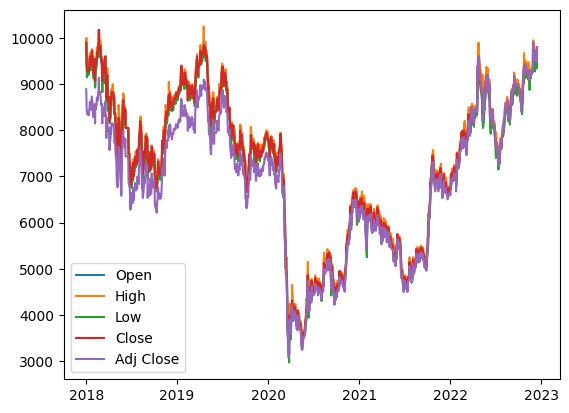

In [18]:
# BBNI Price plot
SPrice_plot(BBNI_df)

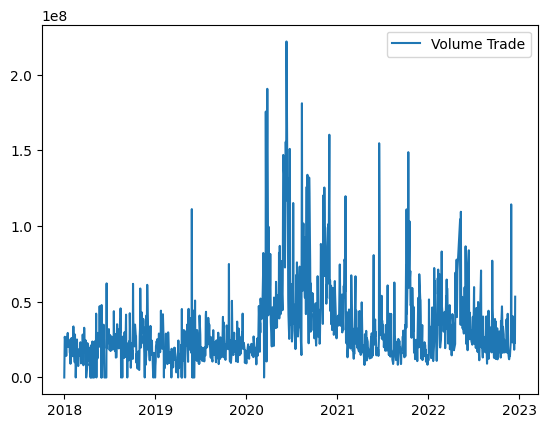

In [19]:
# BBNI Volume Trade
SVol_plot(BBNI_df)

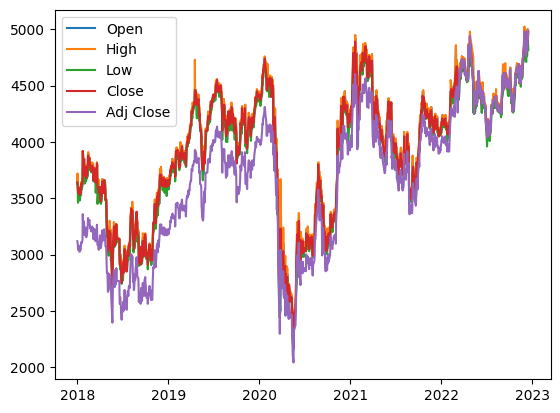

In [20]:
# BBRI Price plot
SPrice_plot(BBRI_df)

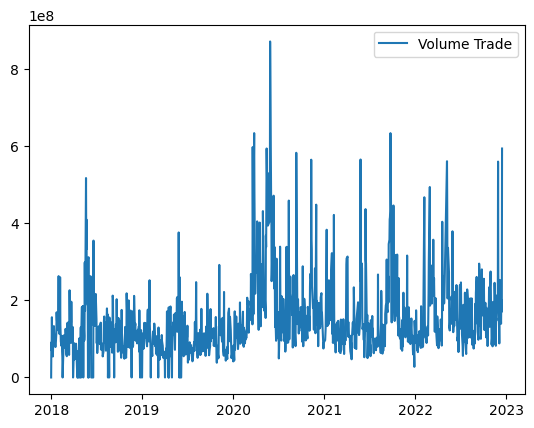

In [21]:
# BBRI Volume Trade
SVol_plot(BBRI_df)

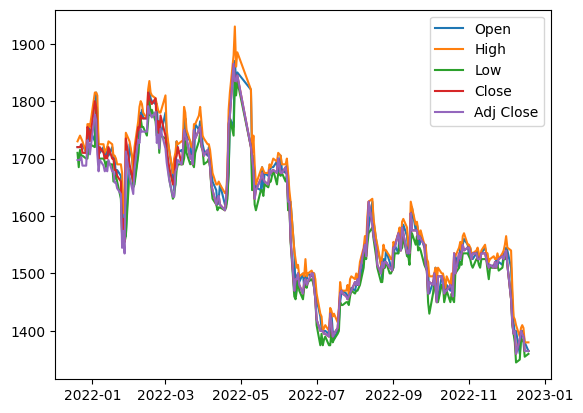

In [22]:
# BBTN Price plot
SPrice_plot(BBTN_df)

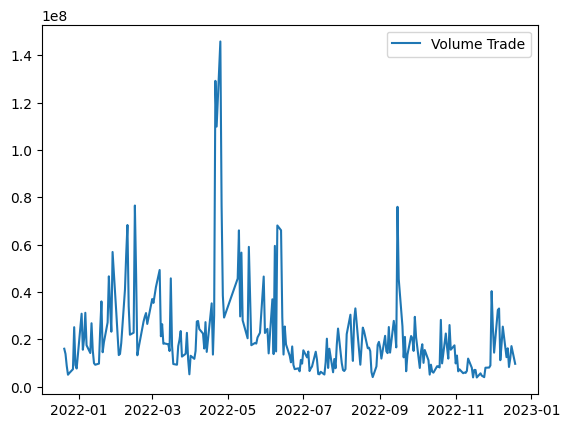

In [23]:
# BBTN Volume Trade
SVol_plot(BBTN_df)

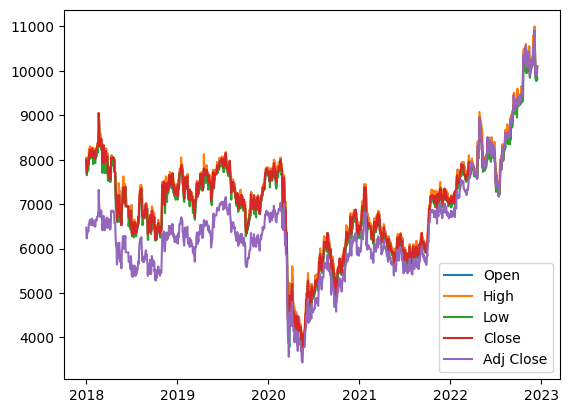

In [24]:
# BMRI Price plot
SPrice_plot(BMRI_df)

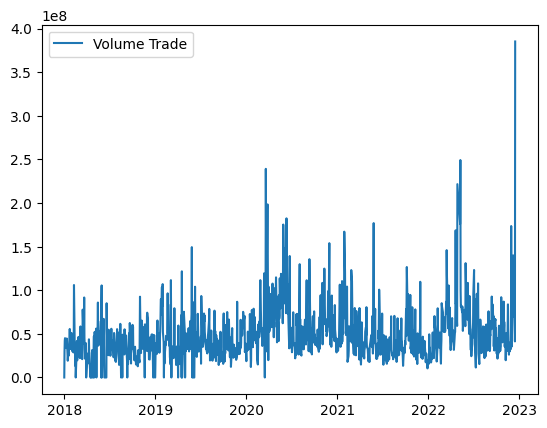

In [25]:
# BMRI Volume Trade
SVol_plot(BMRI_df)

In [26]:
# BBNI Stationarity check

# Adj Close Price
print('Adj Close Stationarity Check')
check_stationarity(BBNI_df['Adj Close'])

# Volume Trade
print('\n Volume Trade Stationarity Check')
check_stationarity(BBNI_df['Volume'])

Adj Close Stationarity Check
ADF Statistic: -1.398850
p-value: 0.582827
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary

 Volume Trade Stationarity Check
ADF Statistic: -4.950119
p-value: 0.000028
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


In [27]:
# BBRI Stationarity check

# Adj Close Price
print('Adj Close Stationarity Check')
check_stationarity(BBRI_df['Adj Close'])

# Volume Trade
print('\n Volume Trade Stationarity Check')
check_stationarity(BBRI_df['Volume'])

Adj Close Stationarity Check
ADF Statistic: -1.578925
p-value: 0.494171
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary

 Volume Trade Stationarity Check
ADF Statistic: -6.520246
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


In [28]:
# BBTN Stationarity check

# Adj Close Price
print('Adj Close Stationarity Check')
check_stationarity(BBTN_df['Adj Close'])

# Volume Trade
print('\n Volume Trade Stationarity Check')
check_stationarity(BBTN_df['Volume'])

Adj Close Stationarity Check
ADF Statistic: -1.767278
p-value: 0.396824
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Non-stationary

 Volume Trade Stationarity Check
ADF Statistic: -6.161922
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Stationary


In [29]:
# BMRI Stationarity check

# Adj Close Price
print('Adj Close Stationarity Check')
check_stationarity(BMRI_df['Adj Close'])

# Volume Trade
print('\n Volume Trade Stationarity Check')
check_stationarity(BMRI_df['Volume'])

Adj Close Stationarity Check
ADF Statistic: -0.484729
p-value: 0.894962
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary

 Volume Trade Stationarity Check
ADF Statistic: -4.890900
p-value: 0.000036
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


Statement :<br>
All adj close prices are in the non-stationary patterns, while the volume trades are in the opposite condition.

### 4. Data Preprocessing
Since the matter thing is closed price, thus we only need the the closing price to make a prediction.

In [33]:
# Define a function for split train-test data
def man_train_test_split(dataframe, test_ratio):
    train_set = dataframe[0:round(len(BBNI_df)*(1 - test_ratio))]
    test_set = dataframe[round(len(BBNI_df)*(1 - test_ratio)):]
    return train_set, test_set

In [34]:
# Take the closing price only
BBNI_raw = BBNI_df.copy().drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
BBRI_raw = BBRI_df.copy().drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
BBTN_raw = BBTN_df.copy().drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
BMRI_raw = BMRI_df.copy().drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)

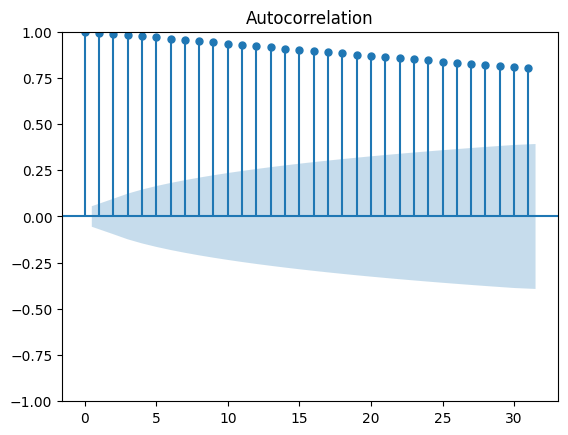

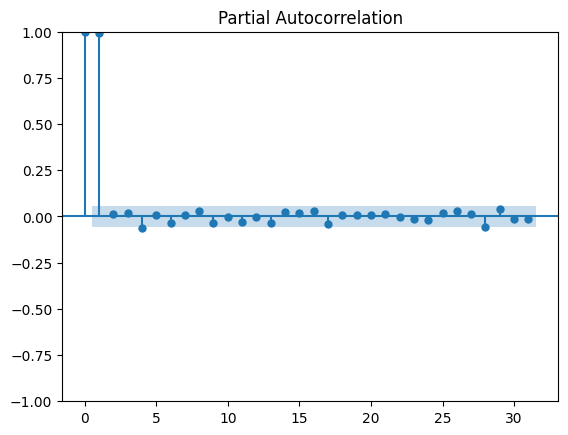

In [35]:
# BBNI Correlation
plot_acf(BBNI_raw['Close'])
plot_pacf(BBNI_raw['Close'])
plt.show()

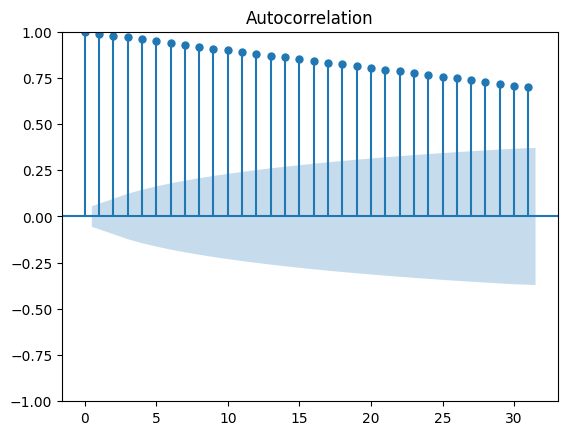

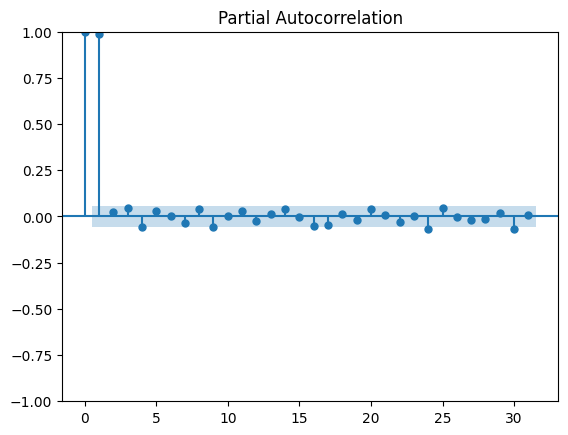

In [36]:
# BBRI Correlation
plot_acf(BBRI_raw['Close'])
plot_pacf(BBRI_raw['Close'])
plt.show()

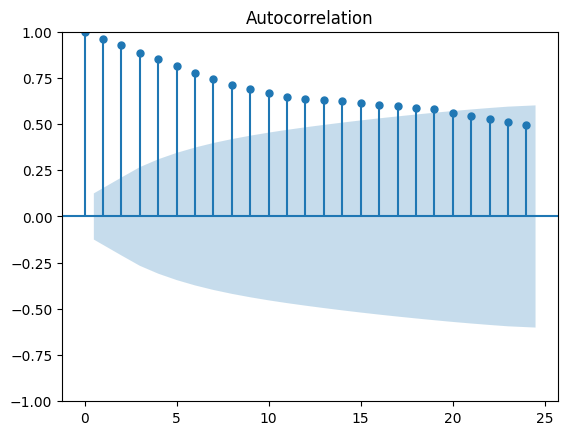

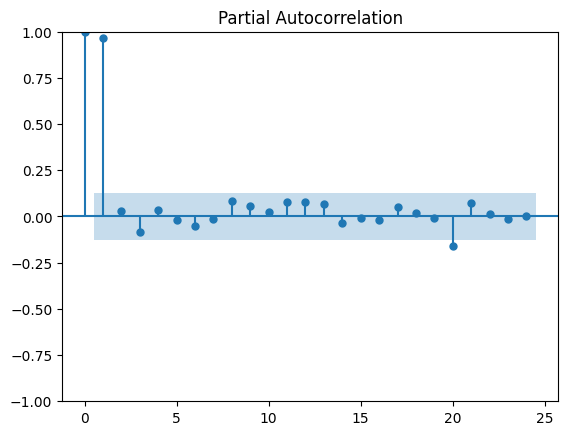

In [37]:
# BBTN Correlation
plot_acf(BBTN_raw['Close'])
plot_pacf(BBTN_raw['Close'])
plt.show()

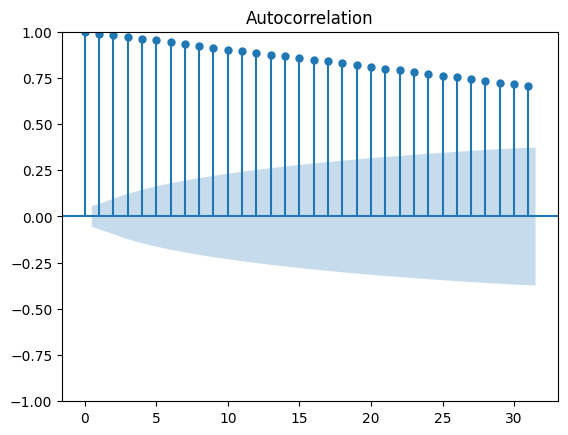

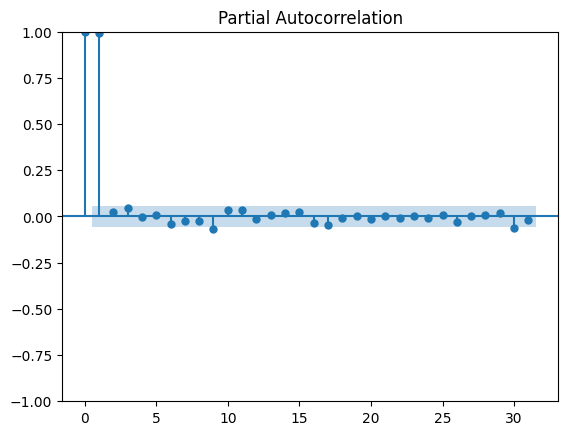

In [38]:
# BMRI Correlation
plot_acf(BMRI_raw['Close'])
plot_pacf(BMRI_raw['Close'])
plt.show()

Statement :<br>
All stocks<br>
ACF : Taill off<br>
PACF : Cuts off

In [44]:
# Set date into index
BBNI_fin = BBNI_raw.set_index('Date')
BBRI_fin = BBRI_raw.set_index('Date')
BBTN_fin = BBTN_raw.set_index('Date')
BMRI_fin = BBNI_raw.set_index('Date')

In [130]:
# Split train-test data
BBNI_train, BBNI_test = man_train_test_split(BBNI_fin, 0.2)
BBRI_train, BBRI_test = man_train_test_split(BBRI_fin, 0.2)
BBTN_train, BBTN_test = man_train_test_split(BBNI_fin, 0.2)
BMRI_train, BMRI_test = man_train_test_split(BBNI_fin, 0.2)

### 5. Model Definition

In [150]:
Arima_BBNI = ARIMA(BBNI_train, order = (2,0,30)) # BBNI Model
Arima_BBRI = ARIMA(BBRI_train, order = (2,0,30)) # BBRI Model
Arima_BBTN = ARIMA(BBTN_train, order = (2,0,30)) # BBTN Model
Arima_BMRI = ARIMA(BMRI_train, order = (2,0,30)) # BMRI Model

### 6. Model Training
### 6.1 ARIMA

In [151]:
# Model training
BBNI_mod_train = Arima_BBNI.fit() # BBNI
BBRI_mod_train = Arima_BBRI.fit() # BBRI
BBTN_mod_train = Arima_BBTN.fit() # BBTN
BMRI_mod_train = Arima_BMRI.fit() # BMRI

In [152]:
# Forecast

# BBNI
y_pred_BBNI = pd.DataFrame(BBNI_mod_train.forecast(len(BBNI_test)))
y_pred_BBNI.index = BBNI_test.index

# BBRI
y_pred_BBRI = pd.DataFrame(BBRI_mod_train.forecast(len(BBRI_test)))
y_pred_BBRI.index = BBRI_test.index

# BBTN
y_pred_BBTN = pd.DataFrame(BBTN_mod_train.forecast(len(BBTN_test)))
y_pred_BBTN.index = BBTN_test.index

# BMRI
y_pred_BMRI = pd.DataFrame(BMRI_mod_train.forecast(len(BMRI_test)))
y_pred_BMRI.index = BMRI_test.index

In [153]:
# Combine test set and predict set
BBNI_act_pred = pd.merge(BBNI_test, y_pred_BBNI, left_index = True, right_index = True) # BBNI
BBRI_act_pred = pd.merge(BBRI_test, y_pred_BBRI, left_index = True, right_index = True) # BBRI
BBTN_act_pred = pd.merge(BBTN_test, y_pred_BBTN, left_index = True, right_index = True) # BBTN
BMRI_act_pred = pd.merge(BMRI_test, y_pred_BMRI, left_index = True, right_index = True) # BMRI

### 6.2 SARIMAX

In [159]:
BBNI_SAR = sm.tsa.statespace.SARIMAX(BBNI_train, order=(2, 0, 5),seasonal_order=(2,0,5,31)).fit()
BBRI_SAR = sm.tsa.statespace.SARIMAX(BBRI_train, order=(2, 0, 5),seasonal_order=(2,0,5,31)).fit()
BBTN_SAR = sm.tsa.statespace.SARIMAX(BBTN_train, order=(2, 0, 5),seasonal_order=(2,0,5,31)).fit()
BMRI_SAR = sm.tsa.statespace.SARIMAX(BMRI_train, order=(2, 0, 5),seasonal_order=(2,0,5,31)).fit()

KeyboardInterrupt: 

### 7. Model Evaluation

In [154]:
def MAE_cal(act_dataframe, pred_dataframe):
    print('MAE :', mean_absolute_error(act_dataframe, pred_dataframe))
    print('MSE :', mean_squared_error(act_dataframe, pred_dataframe))
    print('RMSE :', np.sqrt(mean_squared_error(act_dataframe, pred_dataframe)))
    plt.plot(act_dataframe.index, act_dataframe, label = 'Actual')
    plt.plot(pred_dataframe.index, pred_dataframe, label = 'Prediction')
    plt.legend()
    plt.show()

MAE : 1416.6199177071092
MSE : 2580842.856982558
RMSE : 1606.5001889145728


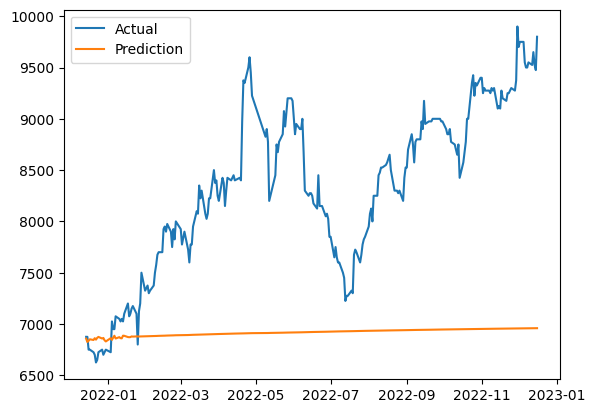

In [155]:
MAE_cal(BBNI_test, y_pred_BBNI)

### 8. Model Inference

## Conclusions, Assumptions, Overall Analysis

`put your conclusions here`